Copyright 2019, Pavel Eftimovski, All rights reserved.

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import warnings; 
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from imblearn.pipeline import Pipeline as imbPipeline
from importlib import reload 
import ipynb.fs.full.USAID_support_functions as psf
reload(psf)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings; 
warnings.filterwarnings('ignore')

In [2]:
# import train data
files_path = '.../USAID_Data/selected features/'

tr_pred_names = ['s_objects',
                 's_num_log',
                 'si', 'sc',
                 'sv', 'sm',
                 'sb', 'sml',
                 'trending']

file_dict = psf.import_sel_data(files_path + 'train/predictors/', tr_pred_names)

print(file_dict.keys(), "\n", [df.shape for df in file_dict.values()])

for key, df in file_dict.items():
    print("\n", key, ":\n", df.dtypes)

s_objects, s_num_log, si, sc, sv, sm, sb, sml, trending = [file_dict[f] for f in tr_pred_names]

s_objects = s_objects.apply(lambda elem: pd.Categorical(elem))

# drop redundant columns
entities = ['country',
            'manu_site',
            'vendor',
            'brand',
            'mol_test']

for s in [sc, sv, sm, sb, sml]:
    for e in entities:
        try:
            s.drop(e, axis=1, inplace=True)
        except:
            pass
        
# import responses
delayed_del = pd.read_csv(files_path + 'train/responses/' + 'delayed_del.csv')
delayed_del = delayed_del.apply(lambda elem: pd.Categorical(elem))

datetime64 = pd.read_csv(files_path + 'train/responses/' + 'datetime64.csv')
datetime64['delay_t'] = datetime64['delay_t'].apply(lambda elem: pd.to_timedelta(elem))

dict_keys(['s_objects', 's_num_log', 'si', 'sc', 'sv', 'sm', 'sb', 'sml', 'trending']) 
 [(8259, 29), (8259, 17), (8259, 5), (8259, 3), (8259, 6), (8259, 2), (8259, 1), (8259, 2), (8259, 6)]

 s_objects :
 po_new_date_mn         int64
po_new_date_dy         int64
sch_del_date_mn        int64
sch_del_date_dy        int64
po_new_date_wd         int64
po_new_date_wk         int64
po_new_date_qt         int64
sch_del_date_wd        int64
sch_del_date_wk        int64
sch_del_date_qt        int64
managed_by            object
flf_via               object
vendor                object
ship_mode             object
product_grp           object
sub_class             object
mol_test              object
brand                 object
dosage                object
dos_form              object
manu_site             object
first_line            object
c_ship                object
sep_weight            object
sep_freight           object
cmdty_cost_freight    object
country               object
manu_countr

In [3]:
# balance dummy values for train/test categorical data
s_ts_objects = pd.read_csv(files_path + 'test/predictors/' + 's_ts_objects.csv')
s_ts_objects = s_ts_objects.apply(lambda elem: pd.Categorical(elem))

# transform data
s_objects, s_ts_objects = psf.cat_pipeline(s_objects, s_ts_objects)

train_data, delayed_del_tr = psf.transform_pipepline(s_objects,
                                                     s_num_log,
                                                     si, sc, sv,
                                                     sm, sb, sml,
                                                     trending,
                                                     delayed_del)

X shape:  (8259, 695) 
y shape: (8259, 1)


In [4]:
# import classifiers
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

Shape of X_train: (6607, 695) X_val: (1652, 695) y_train: (6607, 1) y_val: (1652, 1)


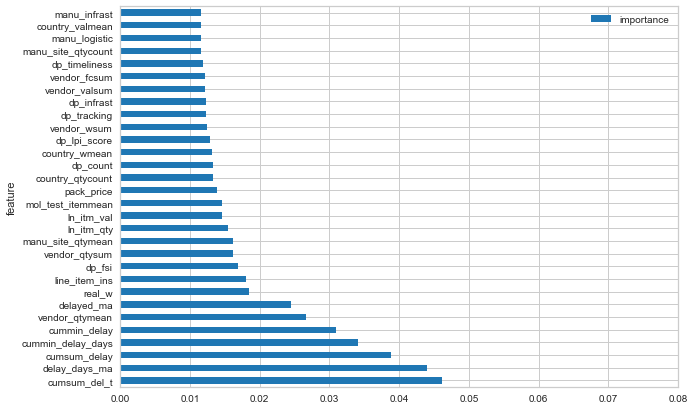

In [5]:
# Benchmark: RandomForestClassifier 
psf.fix_nulls(train_data) # fix nan values

X, y = train_data, delayed_del_tr

# train-validation split
X_train_c, X_val_c, y_train_c, y_val_c = psf.split_set(X, y, 0.2, use_smote=False)

# fit
random_forest = RandomForestClassifier(random_state=109)
random_forest.fit(X_train_c, y_train_c)

# visualize
psf.visualize_importance(random_forest, X_train_c, 0.08)

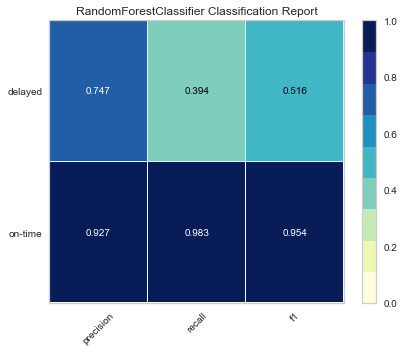

In [6]:
# evaluation
plt.subplots(figsize=(6,5))
psf.class_report(X_train_c, X_val_c, y_train_c, y_val_c, random_forest)

True positives:
 delayed_del    74
prediction     74
dtype: int64


Text(0.5, 1.0, 'Blue: Predicted | Green: Actual')

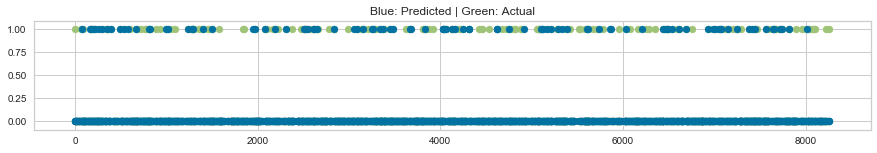

In [7]:
# predict
y_pred = random_forest.predict(X_val_c)
pred_df = y_val_c.copy()
pred_df['prediction']= y_pred
#print(pred_df.describe())

# create df of true positives
true_pred_df = pred_df[(pred_df.delayed_del==1) & (pred_df.delayed_del==pred_df.prediction)]
#print(true_pred_df.sum())

print("True positives:\n", true_pred_df.sum())

# visualize prediction
plt.subplots(figsize=(15,2))
plt.scatter(pred_df.index, pred_df.iloc[:,0], color='g')
plt.scatter(pred_df.index, pred_df.iloc[:,1], color='b')
plt.title("Blue: Predicted | Green: Actual")

In [6]:
# import regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

Shape of X_train: (876, 695) X_val: (74, 695) y_train: (876,) y_val: (74,)


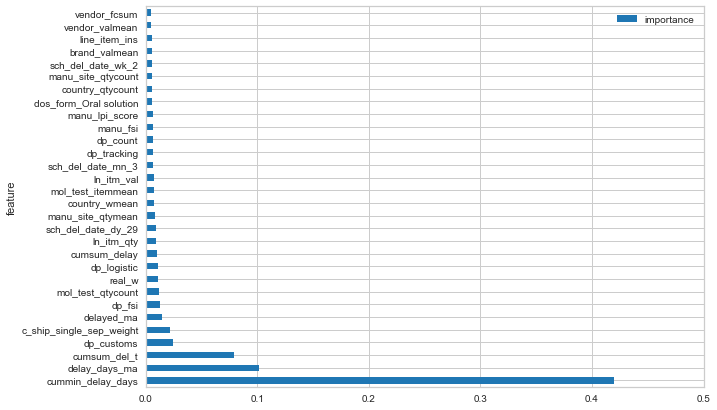

In [9]:
# Benchmark: RandomForestRegressor
X_train_r, X_val_r, y_train_r, y_val_r = psf.split_set_reg(X, true_pred_df, datetime64, y)

reg = RandomForestRegressor(random_state=110)
reg.fit(X_train_r, y_train_r)

psf.visualize_importance(reg, X_train_r, 0.5)

R-Squared:  0.7829504310182616 RMSE : 18.501318433662604 Target Variable Mean:  31.7972972972973


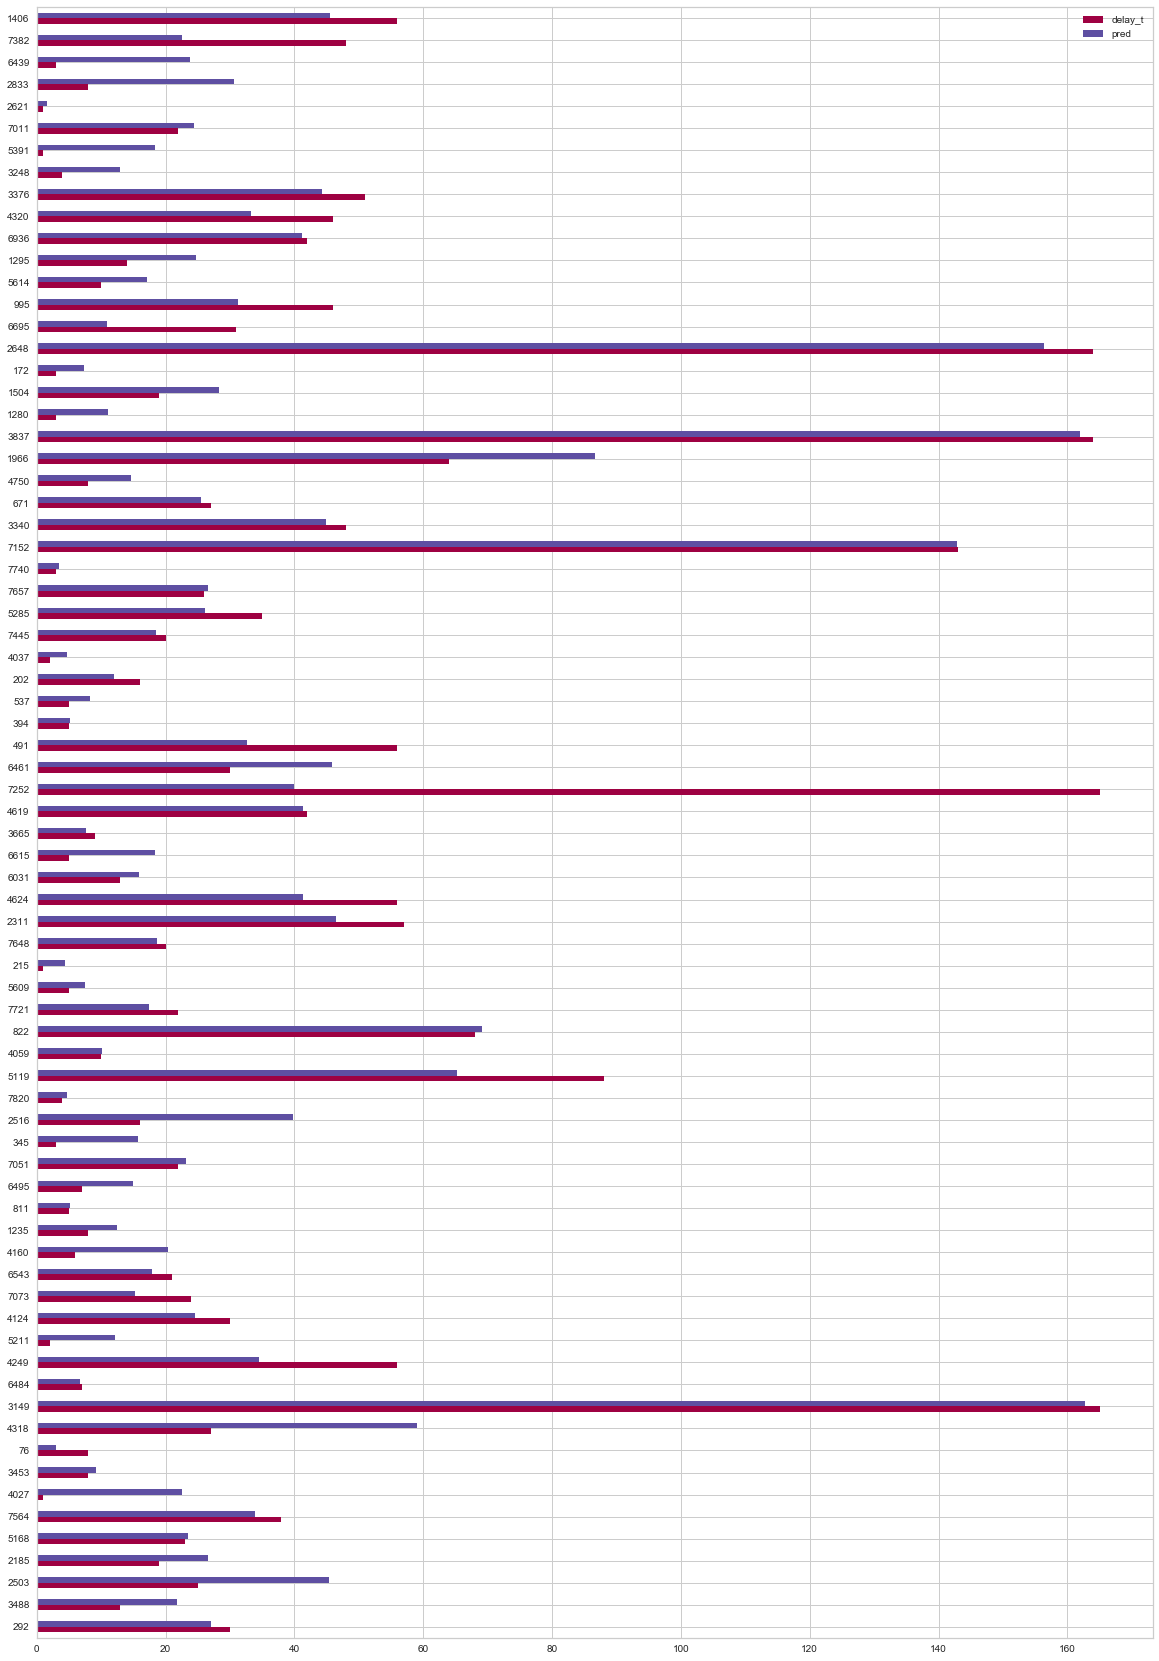

In [10]:
# reg predict
y_pred_reg = reg.predict(X_val_r)

# accuracy and error calcs
r2, rmse = metrics.r2_score(y_val_r, y_pred_reg), np.sqrt(metrics.mean_squared_error(y_val_r, y_pred_reg))
print("R-Squared: ", r2, "RMSE :", rmse, "Target Variable Mean: ", y_val_r.mean())

# pred vs. delay_t
df_pred_reg =pd.DataFrame(y_val_r)
df_pred_reg['pred']= y_pred_reg
df_pred_reg.plot(kind="barh", figsize=(20,30), cmap="Spectral")

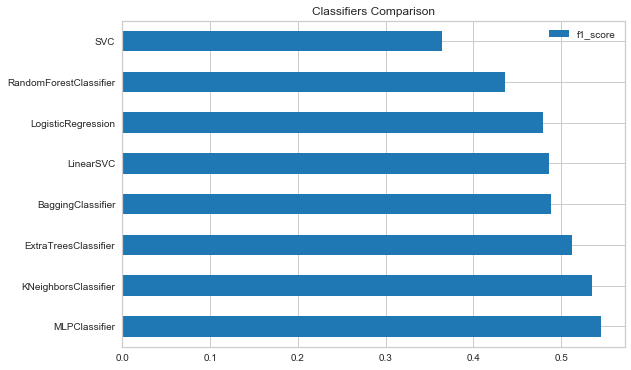

In [8]:
## Select classifier ##
classifiers = [KNeighborsClassifier,
               RandomForestClassifier,
               ExtraTreesClassifier,
               BaggingClassifier,
               MLPClassifier,
               LogisticRegression,
               LinearSVC,
               SVC]

clfs_names = ['KNeighborsClassifier',
              'RandomForestClassifier',
              'ExtraTreesClassifier',
              'BaggingClassifier',
              'MLPClassifier',
              'LogisticRegression',
              'LinearSVC',
              'SVC']   

# append scores for each clf
f1s = []
for c in classifiers:
    try:
        f1s.append(psf.select_classifier(X_train_c, X_val_c, y_train_c, y_val_c, c()))
    except:
        f1s.append(0)

f1_df = pd.DataFrame(f1s, clfs_names)
f1_df.columns = ["f1_score"]
f1_df.sort_values(by ='f1_score',ascending=False).plot(kind="barh",
                                                       title="Classifiers Comparison",
                                                       figsize=(9,6),
                                                       cmap="tab10")

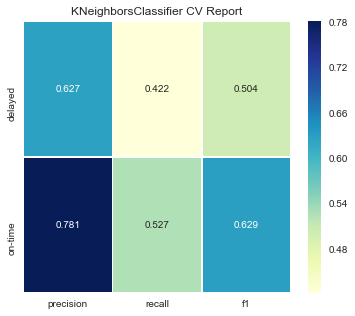

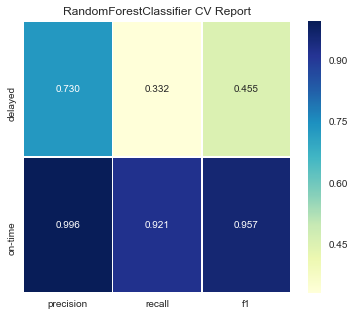

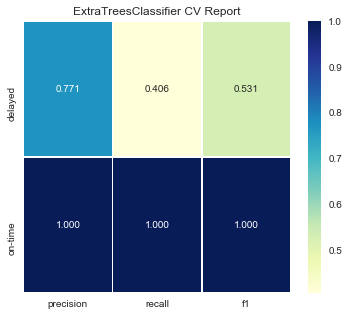

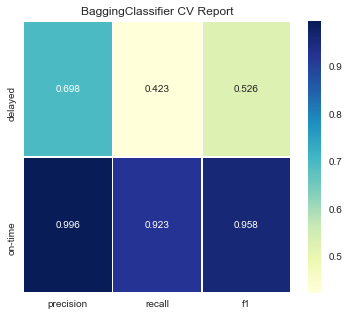

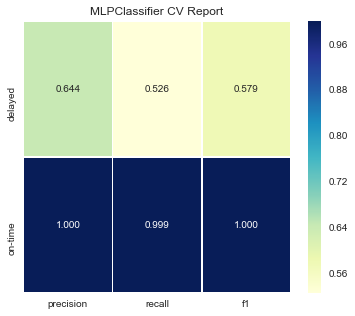

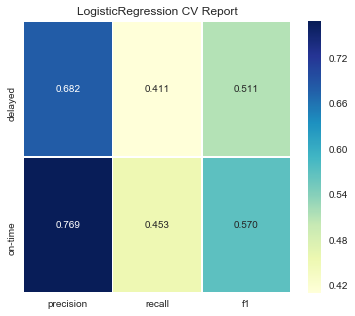

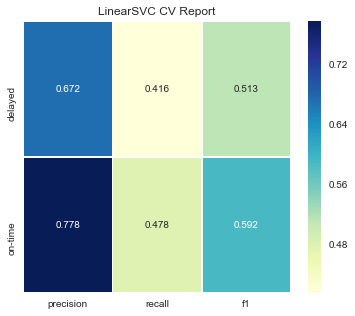

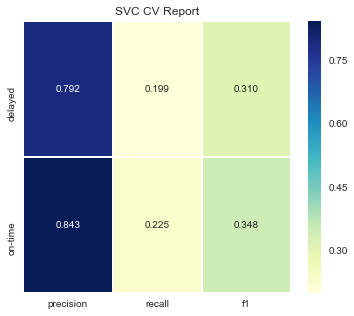

In [9]:
# cross-validation reports
for c in classifiers:
    i=classifiers.index(c)
    psf.cross_val_report(classifiers[i](), X, y, clfs_names[i]+' CV Report')

In [8]:
# collect true positives from MLPClassifier
sel_clf = MLPClassifier(random_state=102)
sel_tr_pred = psf.collect_tr_pred(sel_clf, X_train_c, X_val_c, y_train_c, y_val_c)

True positives:
 delayed_del    93
prediction     93
dtype: int64


Shape of X_train: (857, 695) X_val: (93, 695) y_train: (857,) y_val: (93,)


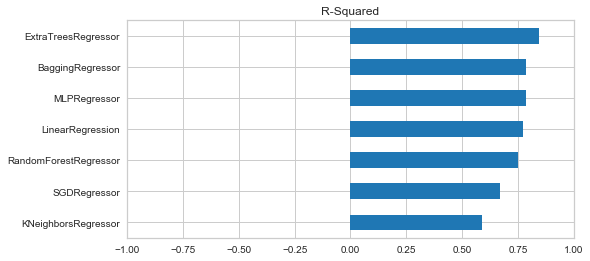

In [9]:
# Select regressor
X_train_r, X_val_r, y_train_r, y_val_r = psf.split_set_reg(X, sel_tr_pred, datetime64, y)

regressors = [KNeighborsRegressor,
              SGDRegressor,
              BaggingRegressor,
              RandomForestRegressor,
              ExtraTreesRegressor,
              MLPRegressor,
              LinearRegression]

reg_names = ['KNeighborsRegressor',
             'SGDRegressor',
             'BaggingRegressor',
             'RandomForestRegressor',
             'ExtraTreesRegressor',
             'MLPRegressor',
             'LinearRegression'] 

# collect r2, rmse scores
r_scores = []
for reg in regressors:
    try:
        r_scores.append(psf.select_regressor(X_train_r, X_val_r, y_train_r, y_val_r, reg()))
    except:
        r_scores.append((0,0))

# plot regression scores
r2_rmse_df = pd.DataFrame(r_scores, reg_names, columns=['r2', 'rmse'])
r2_rmse_df['r2'].sort_values().plot(kind="barh", xlim=(-1,1), title="R-Squared", figsize=(8,4), cmap="tab20")

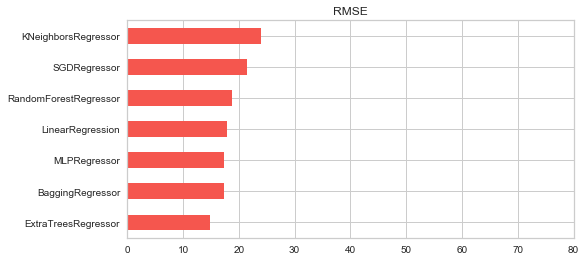

In [10]:
r2_rmse_df['rmse'].sort_values().plot(
                    kind="barh", xlim=(0,80)
                    , title="RMSE"
                    , figsize=(8,4), color="#f5564e")

In [11]:
r2_rmse_df.sort_values('r2', ascending=False)

,r2,rmse
ExtraTreesRegressor,0.844223,14.806937
BaggingRegressor,0.787653,17.287636
MLPRegressor,0.785857,17.360611
LinearRegression,0.773821,17.841822
RandomForestRegressor,0.749958,18.759433
SGDRegressor,0.669920,21.553715
KNeighborsRegressor,0.588828,24.056072


In [12]:
print("R-squared: \n")
for row in r2_rmse_df['r2'].items():
    print(row)

print("\n\nRMSE: \n")
for row in r2_rmse_df['rmse'].items():
    print(row)

R-squared: 

('KNeighborsRegressor', 0.588827825768071)
('SGDRegressor', 0.6699204942842644)
('BaggingRegressor', 0.7876533086138048)
('RandomForestRegressor', 0.7499575727324586)
('ExtraTreesRegressor', 0.8442225063157036)
('MLPRegressor', 0.7858567994819221)
('LinearRegression', 0.773820795958221)


RMSE: 

('KNeighborsRegressor', 24.056072490244826)
('SGDRegressor', 21.55371548344396)
('BaggingRegressor', 17.28763620601145)
('RandomForestRegressor', 18.759433469218134)
('ExtraTreesRegressor', 14.806936764371153)
('MLPRegressor', 17.36061116991437)
('LinearRegression', 17.841821958160967)


In [7]:
# run variations of classifiers and regressors

'''Classifiers'''
# temp_clf = ExtraTreesClassifier(n_estimators=1500,
#                                 criterion='gini',
#                                 max_depth=100,
#                                 min_samples_split=2,
#                                 min_samples_leaf=1,
#                                 min_weight_fraction_leaf=0.0,
#                                 max_features=100,
#                                 min_impurity_decrease=0.0,
#                                 bootstrap=True,
#                                 n_jobs=None,
#                                 random_state=998)

# temp_clf = BaggingClassifier(base_estimator=None,
#                              n_estimators=50,
#                              max_samples=1.0,
#                              max_features=1.0,
#                              bootstrap=True,
#                              bootstrap_features=True, 
#                              oob_score=False,
#                              warm_start=True,
#                              random_state=997)

temp_clf = MLPClassifier(hidden_layer_sizes=(100),
                         activation='relu',
                         solver='adam',
                         alpha=0.0001,
                         batch_size='auto',
                         learning_rate='constant',
                         learning_rate_init=0.001,
                         max_iter=700,
                         shuffle=True,
                         random_state=1,
                         tol=0.0001)

'''Regressors'''
temp_reg = ExtraTreesRegressor(n_estimators=900,
                               max_features=50,
                               max_depth=30,
                               random_state=2)

# temp_reg = MLPRegressor(hidden_layer_sizes=(100,10,30),
#                          activation='relu',
#                          solver='adam',
#                          alpha=0.0001,
#                          batch_size='auto',
#                          learning_rate='constant',
#                          learning_rate_init=0.001,
#                          random_state=151)                    

pred_df_cr, tr_pred_cr,  clf_importance, clf_report \
          , conf_mtrx, r2_reg, rmse_reg = psf.classify_regress(X, y,
                                                               datetime64,
                                                               temp_clf,
                                                               temp_reg,
                                                               test_size=0.2,
                                                               use_smote=False)

print("\nConfusion Matrix:\n {} \n \nRSquared: {} \nRMSE: {}".format(
                                                            conf_mtrx,
                                                            r2_reg,
                                                            rmse_reg))

Shape of X_train: (11690, 695) X_val: (1652, 695) y_train: (11690, 1) y_val: (1652, 1)

Can't visualize feature importance for: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 30, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=700, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Shape of X_train: (862, 695) X_val: (88, 695) y_train: (862,) y_val: (88,)

Confusion Matrix:
 [[1406   58]
 [ 100   88]] 
 
RSquared: 0.9065572911595611 
RMSE: 11.678326153954297


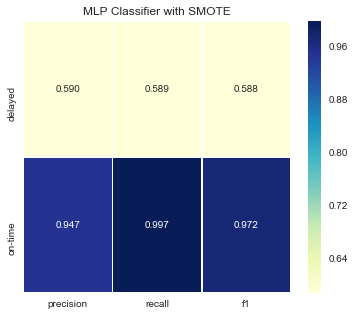

In [13]:
## Classifier Selection ##
fin_clf = MLPClassifier(hidden_layer_sizes=(100),
                        activation='relu',
                        solver='adam',
                        alpha=0.001,
                        batch_size='auto',
                        learning_rate='adaptive',
                        learning_rate_init=0.001,
                        power_t=0.5,
                        max_iter=700,
                        shuffle=True,
                        random_state=17,
                        tol=0.000001,
                        verbose=False,
                        warm_start=False,
                        momentum=0.9,
                        nesterovs_momentum=True,
                        early_stopping=True,
                        validation_fraction=0.1,
                        beta_1=0.9,
                        beta_2=0.999,
                        epsilon=1e-08)

# oversample
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio = 1.0, random_state=145)

pipe = imbPipeline([
    ('oversample', smote),
    ('clf', fin_clf)])

# cross-validate
psf.cross_val_report(pipe, X, y, "MLP Classifier with SMOTE")

In [8]:
## Regressor Selection ##
X_train_cf, X_val_cf, y_train_cf, y_val_cf = psf.split_set(X, y, 0.2, use_smote=True)

# true predictions
clf_true_pred = psf.collect_tr_pred(temp_clf, X_train_cf, X_val_cf, y_train_cf, y_val_cf)

X_train_rf, X_val_rf, y_train_rf, y_val_rf = psf.split_set_reg(X, clf_true_pred, datetime64, y)

fin_reg = ExtraTreesRegressor(n_estimators=900,
                               max_features=100,
                               max_depth=50,
                               random_state=21)

reg_score = []
reg_score.append(psf.select_regressor(X_train_rf, X_val_rf, y_train_rf, y_val_rf, fin_reg))
print("\n-R-Squared: ", reg_score[0][0]," \n-RMSE:", reg_score[0][1])

Shape of X_train: (11690, 695) X_val: (1652, 695) y_train: (11690, 1) y_val: (1652, 1)
True positives:
 delayed_del    88
prediction     88
dtype: int64
Shape of X_train: (862, 695) X_val: (88, 695) y_train: (862,) y_val: (88,)

-R-Squared:  0.9065572911595611  
-RMSE: 11.678326153954297


In [6]:
## Import Test Data ##
ts_pred_names = ['s_ts_num_log',
                 'sti', 'stc',
                 'stv', 'stm',
                 'stb', 'stml',
                 'trending_ts']

ts_file_dict = psf.import_sel_data(files_path + 'test/predictors/', ts_pred_names)

print(ts_file_dict.keys(), "\n", [df.shape for df in ts_file_dict.values()])

for key, df in ts_file_dict.items():
    print("\n", key, ":\n", df.dtypes)

s_ts_num_log, sti, stc, stv, stm, stb, stml, trending_ts = [ts_file_dict[f] for f in ts_pred_names]

# drop redundant columns
entities =['country',
           'manu_site',
           'vendor',
           'brand',
           'mol_test']

for s in [stc, stv, stm, stb, stml]:
    for e in entities:
        try:
            s.drop(e, axis=1, inplace=True)
        except:
            pass
        
# import responses
delayed_del_ts = pd.read_csv(files_path + 'test/responses/' + 'delayed_del_ts.csv')
delayed_del_ts = delayed_del_ts.apply(lambda elem: pd.Categorical(elem))

datetime64_ts = pd.read_csv(files_path + 'test/responses/' + 'datetime64_ts.csv')
datetime64_ts['delay_t'] = datetime64_ts['delay_t'].apply(lambda elem: pd.to_timedelta(elem))

dict_keys(['s_ts_num_log', 'sti', 'stc', 'stv', 'stm', 'stb', 'stml', 'trending_ts']) 
 [(2065, 17), (2065, 5), (2065, 3), (2065, 6), (2065, 2), (2065, 1), (2065, 2), (2065, 6)]

 s_ts_num_log :
 manu_logistic      float64
manu_infrast       float64
manu_lpi_score     float64
manu_customs       float64
manu_tracking      float64
manu_shipments     float64
manu_timeliness    float64
manu_fsi           float64
dp_shipments       float64
dp_timeliness      float64
dp_tracking        float64
dp_customs         float64
dp_lpi_score       float64
dp_infrast         float64
dp_logistic        float64
dp_count             int64
dp_fsi             float64
dtype: object

 sti :
 ln_itm_qty         int64
ln_itm_val       float64
pack_price       float64
line_item_ins    float64
real_w           float64
dtype: object

 stc :
 country_qtycount      int64
country_valmean     float64
country_wmean       float64
dtype: object

 stv :
 vendor_qtysum       int64
vendor_qtymean    float64
vendor_valsum  

In [7]:
# transform test data
test_data, delayed_del_ts = psf.transform_pipepline(s_ts_objects,
                                                    s_ts_num_log,
                                                    sti, stc, stv,
                                                    stm, stb,stml,
                                                    trending_ts,
                                                    delayed_del_ts)

X shape:  (2065, 695) 
y shape: (2065, 1)


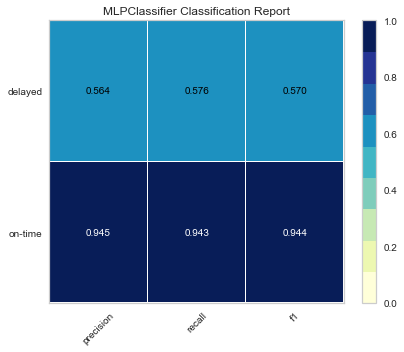

In [13]:
## Test classifier on unseen data ##

psf.fix_nulls(test_data)
X_test, y_test = test_data, delayed_del_ts

clf_smote_pipe = imbPipeline([
                            ('oversample', smote),
                            ('clf', fin_clf)])

plt.subplots(figsize=(6,5))
psf.class_report(X, X_test, y, y_test, clf_smote_pipe)

In [13]:
## Test regressor on unseen data ##

test_pred = clf_smote_pipe.predict(X_test)
ts_pred_df = y_test.copy()
ts_pred_df['prediction'] = test_pred
true_ts_pred = ts_pred_df[(ts_pred_df.delayed_del==1) & (ts_pred_df.delayed_del==ts_pred_df.prediction)]

# construct data for reg test
X_fr = X.loc[y[y==1].dropna().index.tolist(),:]
X_test_fr = X_test.loc[true_ts_pred.index.tolist(),:]
y_r_total = datetime64.loc[y[y==1].dropna().index.tolist(),['delay_t']]
y_fr = y_r_total.delay_t.dt.days
y_test_fr = datetime64_ts.loc[true_ts_pred.index.tolist(),['delay_t']]['delay_t'].dt.days

# score
test_reg_score = []
test_reg_score.append(psf.select_regressor(X_fr, X_test_fr, y_fr, y_test_fr, fin_reg))
print("\n-R-Squared: ", test_reg_score[0][0]," \n-RMSE:", test_reg_score[0][1])


-R-Squared:  0.9026142397834055  
-RMSE: 11.720131596094419


In [20]:
# export final model
import pickle
model_path = '.../USAID_Data/final model/'
clf_file = 'MLP_Classifier.sav'
pickle.dump(clf_smote_pipe, open(model_path + clf_file, 'wb'))
reg_file = 'ExtraTrees_Regressor.sav'
pickle.dump(fin_reg, open(model_path + reg_file, 'wb'))